# Sourcing Agent Prototype using LangGraph


# Sourcing Agent Build

Agent: 
Resume sourcing from a set of job requirement and a set of resume

Inputs: 
- linkedin profile(s) as resume
- job requirement

Tasks:
- Get linkedin profile and safe
- Evaluate the resume to the job requirement, score
- Decide to send email or not from score
- Write email, some initial questions from the resume screening process
- Send email

Tools:
- Web scrape, linkedin
- Profile reader/writer to document
- Job requirement reader/retrieval?
- Send Email







In [6]:
from typing import Dict, List, Tuple, Any, Annotated, TypedDict
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, AnyMessage
from langchain_core.tools import BaseTool
from langgraph.graph import START, StateGraph, END
from langchain_core.agents import AgentAction, AgentFinish
from langchain_openai import ChatOpenAI
import operator
from langchain_core.utils.function_calling import convert_to_openai_function
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.graph.message import add_messages
from langgraph.prebuilt import tools_condition # this is the checker for the
from langgraph.prebuilt import ToolNode

from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

from IPython.display import Image, display
import os

from dotenv import load_dotenv
load_dotenv()

openai_api = os.getenv("OPENAI_API_KEY")
if openai_api is None:
    raise ValueError("Please set the OPENAI_API_KEY environment variable")
os.environ["OPENAI_API_KEY"] = openai_api

In [7]:
# Tools

def file_read(file_dir: str) -> str:
    """
    Read file from a directory 

    Args:
        file_dir: directory of file to be read        
    """

    file = os.listdir(file_dir)[0]
    file_path = os.path.join(file_dir, file)
    
    try:
        with open(file_path, "r") as file:
            return file.read()
    except FileNotFoundError:
        return f"Error: File not found at path: {file_path}"
    except PermissionError:
        return f"Error: Permission denied when trying to read file: {file_path}"
    except Exception as e:
        return f"Error: Failed to read file {file_path}. {str(e)}"


# def pull_resume(linkedin_URL: int) -> str:
#     """pull linkedin profile from a linkedin profile URL.

#     Args:
#         linkedin_URL: URL of linkedin profile        
#     """

#     # placeholder to pulling linkedin URL, replace this later
#     resume_folder = "resume"
#     resume_file = os.listdir(resume_folder)[0]
#     with open(os.path.join(resume_folder, resume_file), 'r') as file:
#         profile_raw = file.read()

#     return profile_raw

# def pull_job_desc() -> str:
#     """no argument, just do pull job description for current task.

#     Args:
          
#     """

#     job_folder = "job"
#     job_file = os.listdir(job_folder)[0]
#     with open(os.path.join(job_folder, job_file), 'r') as file:
#         profile_raw = file.read()

#     return profile_raw

In [8]:
from langchain_core.runnables.graph import CurveStyle

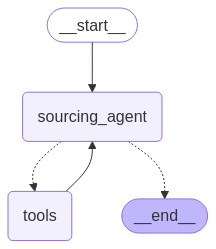

In [ ]:
# Agent

llm = ChatOpenAI(model="gpt-4o-mini")

tools = [file_read]
llm_with_tools = llm.bind_tools(tools)

sys_msg = SystemMessage(content="You are a helpful assistant tasked with sourcing candidate resume, evaluate his/her resume to the job posting, and deciding if they suit the position or not.")

def sourcing_agent(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

def profiler_agent(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

builder = StateGraph(MessagesState)

builder.add_node("sourcing_agent", sourcing_agent)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "sourcing_agent") 
builder.add_conditional_edges( #conditional edge for tool
    "sourcing_agent", 
    tools_condition
)
builder.add_edge("tools", "sourcing_agent") #back to agent

react_graph = builder.compile()

display(Image(react_graph.get_graph(xray=True).draw_mermaid_png(curve_style = CurveStyle.BASIS)))

In [4]:
messages = [HumanMessage(content="Do your task for this linkedin profile https://www.linkedin.com/in/wicaksono-ilham/")]
messages = react_graph.invoke({"messages": messages})   

In [5]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Do your task for this linkedin profile https://www.linkedin.com/in/wicaksono-ilham/
================================== Ai Message ==================================
Tool Calls:
  pull_resume (call_mcu4OxDoLDbUfvJM3Z8w9Haq)
 Call ID: call_mcu4OxDoLDbUfvJM3Z8w9Haq
  Args:
    linkedin_URL: 1869442940
  pull_job_desc (call_Z4O3ULqkJdqsPzZ1f9vgcl7L)
 Call ID: call_Z4O3ULqkJdqsPzZ1f9vgcl7L
  Args:
================================= Tool Message =================================
Name: pull_resume

Ilham Wicaksono
MSc Artificial Intelligence for Sustainable Development @UCL
London, England, United Kingdom
Summary
Hello there! I am Ilham, a passionate multi-discipline engineer and
an avid explorer on emergent technologies. Currently focusing on
applied AI and sustainable development.
Experience
Capgemini
Graduate Student Researcher
November 2024 - February 2025 (4 months)
London Area, United Kingdom
- Develop fram

# Next step for testbed development

- Build into SoTA architechtures (leader, more specific sys_prompt, etc.)
- Add relevant tools
- Downstream tasks on recruitment agent